In [7]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2
# import albumentations as A
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import numpy as np
from segmentation_models_pytorch import Unet
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [10]:
WBC_1_train_dir = 'WBC_1/train/data'
WBC_1_train_mask_dir = 'WBC_1/train/mask'
WBC_1_train_pred_mask_dir = 'WBC_1/train/pred_mask'
WBC_10_train_dir = 'WBC_10/train/data'
WBC_10_train_mask_dir = 'WBC_10/train/mask'
WBC_10_train_pred_mask_dir = 'WBC_10/train/pred_mask'
WBC_50_train_dir = 'WBC_50/train/data'
WBC_50_train_mask_dir = 'WBC_50/train/mask'
WBC_50_train_pred_mask_dir = 'WBC_50/train/pred_mask'
WBC_100_train_dir = 'WBC_100/train/data'
WBC_100_train_mask_dir = 'WBC_100/train/mask'
WBC_100_train_pred_mask_dir = 'WBC_100/train/pred_mask'
WBC_100_val_dir = 'WBC_100/val/data'
CAM16_100_train_dir = 'CAM16_100cls_10mask/train/data'
CAM16_100_train_mask_dir = 'CAM16_100cls_10mask/train/mask'
CAM16_100_val_dir = 'CAM16_100cls_10mask/val/data'
CAM16_100_test_dir = 'CAM16_100cls_10mask/test/data'
CAM16_100_pred_mask_dir = 'CAM16_100cls_10mask/train/pred_mask'
model_load_path = ""
model_save_path = "UNet_CAM16_model.pth" # change

resize = 256

train_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.Normalize([0.485, 0.456, 0.406, 0.0], [0.229, 0.224, 0.225, 1.0])
])

test_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

common_transform = transforms.Compose([
transforms.RandomRotation(360),
transforms.RandomResizedCrop(resize),
])

color_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

proportion = 10
WBC_train_dir = 'WBC_' + str(proportion) + '/train/data'
WBC_mask_dir = 'WBC_' + str(proportion) + '/train/mask'
WBC_pred_mask_dir ='WBC_' + str(proportion) + '/train/pred_mask'

id_to_label = {0: 'normal', 1: 'tumor'}
label_to_id = {'normal': 0, 'tumor': 1}

class TrainDataset(Dataset):
    def __init__(self, root_dir, mask_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        for subdir in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, subdir)):
                for filename in os.listdir(os.path.join(root_dir, subdir)):
                    if filename.endswith(".jpg"):
                        image_path = os.path.join(root_dir, subdir, filename)
                        mask_path = os.path.join(mask_dir, subdir, filename)
                        if os.path.exists(mask_path):
                            self.image_paths.append(image_path)
                            self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB") 
        mask = Image.open(mask_path).convert("L")

        seed = torch.randint(2147483647, (1,)).item()
        torch.manual_seed(seed)
        image = common_transform(image)
        torch.manual_seed(seed)
        mask = common_transform(mask)
        image = color_transform(image)
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        image = torch.cat((image, mask), dim=0)
        image = self.transform(image)
        
        label = os.path.basename(os.path.dirname(img_path))
        label = label_to_id[label]
        return image, label


    
class TestDataset(Dataset):
    def __init__(self, root_dir, mask_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        for subdir in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, subdir)):
                for filename in os.listdir(os.path.join(root_dir, subdir)):
                    if filename.endswith(".jpg"):
                        image_path = os.path.join(root_dir, subdir, filename)
                        mask_path = os.path.join(mask_dir, subdir, filename)
                        if not os.path.exists(mask_path):
                            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        image = Image.open(img_path).convert("RGB") 

        image = transforms.ToTensor()(image)
        image = self.transform(image)
        filename = os.path.basename(img_path)
        
        label = os.path.basename(os.path.dirname(img_path))
        label = label_to_id[label]
        return image, label, filename


# train_dataset = TrainDataset(train_dir, mask_dir, train_transform)
# test_dataset = TestDataset(train_dir, mask_dir, test_transform)

train_dataset = TrainDataset(CAM16_100_train_dir, CAM16_100_train_mask_dir, train_transform)
test_dataset = TestDataset(CAM16_100_train_dir, CAM16_100_train_mask_dir, test_transform)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# for images, labels in data_loader:

#     for i in range(len(images)):
#         image = images[i, :3] 
#         mask = images[i, 3] 
#         label = labels[i]
#         print(f"Label: {label.item()}")

#         plt.imshow(image.permute(1, 2, 0))
#         plt.title("Original Image")
#         plt.show()

#         plt.imshow(mask, cmap='gray')
#         plt.title("Mask")
#         plt.show()

Epoch 1, Loss: 0.5678562462329865
Misclassified Pixels: 1348510 / 4849664 (27.81%)
Epoch 2, Loss: 0.4441129744052887
Misclassified Pixels: 849949 / 4849664 (17.53%)
Epoch 3, Loss: 0.3861621916294098
Misclassified Pixels: 781128 / 4849664 (16.11%)
Epoch 4, Loss: 0.37806791067123413
Misclassified Pixels: 749374 / 4849664 (15.45%)
Epoch 5, Loss: 0.4118019104003906
Misclassified Pixels: 749327 / 4849664 (15.45%)
Epoch 6, Loss: 0.35434195697307586
Misclassified Pixels: 739767 / 4849664 (15.25%)
Epoch 7, Loss: 0.3417714759707451
Misclassified Pixels: 813066 / 4849664 (16.77%)
Epoch 8, Loss: 0.33428158462047575
Misclassified Pixels: 766861 / 4849664 (15.81%)
Epoch 9, Loss: 0.37001297175884246
Misclassified Pixels: 782483 / 4849664 (16.13%)
Epoch 10, Loss: 0.33313011229038236
Misclassified Pixels: 732294 / 4849664 (15.10%)
Epoch 11, Loss: 0.3113468736410141
Misclassified Pixels: 738041 / 4849664 (15.22%)
Epoch 12, Loss: 0.3360496088862419
Misclassified Pixels: 720303 / 4849664 (14.85%)
Epoch 1

Epoch 100, Loss: 0.2730466216802597
Misclassified Pixels: 662365 / 4849664 (13.66%)


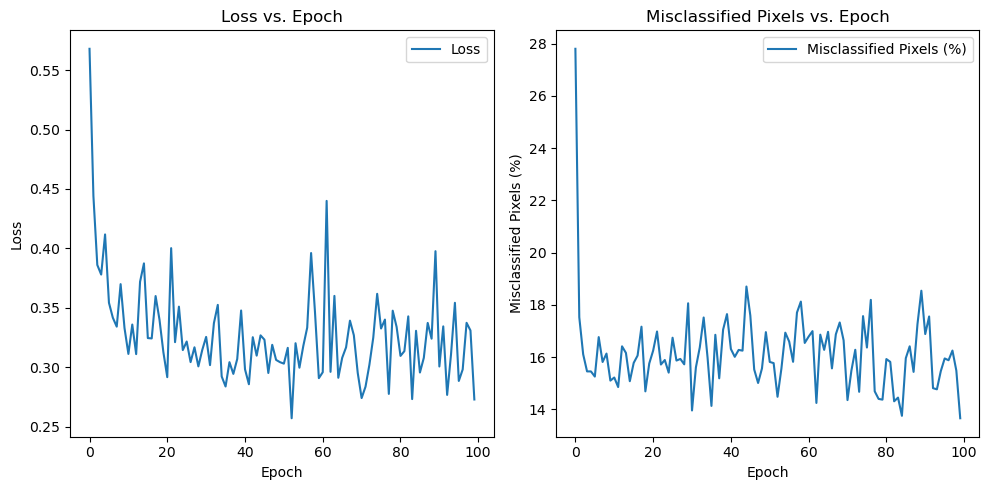

In [13]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet('resnet34', in_channels=3, classes=1).to(device)

height, width = resize, resize
# weight_mask = torch.ones((1, height, width))
# center_h, center_w = height // 2, width // 2

# y, x = torch.meshgrid(torch.arange(height), torch.arange(width))
# distances = torch.sqrt((x - center_w) ** 2 + (y - center_h) ** 2)
# edge_penalty = 0.5
# center_penalty = 2.0
# weight_mask = weight_mask * torch.where(distances <= center_h, center_penalty, edge_penalty)

criterion = nn.BCELoss()

opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
sch = optim.lr_scheduler.StepLR(opt, 5, 0.5)

num_epochs = 100

losses = []
misclassified_pixels_list = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    misclassified_pixels = 0

    for inputs, _ in train_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs[:, 0:3])
        output_probabilities = torch.sigmoid(outputs)
        loss = criterion(output_probabilities.squeeze(1), inputs[:, 3])
#         loss = torch.mean(loss * weight_mask.to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item()
        predicted_mask = (output_probabilities > 0.5)
        misclassified_pixels += torch.sum(predicted_mask.squeeze(1) != inputs[:, 3]).item()
    
    sch.step()   
    total_pixels = len(train_dataloader.dataset) * resize * resize

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}")
    print(f"Misclassified Pixels: {misclassified_pixels} / {total_pixels} ({misclassified_pixels / total_pixels * 100:.2f}%)")
    
    losses.append(running_loss / len(train_dataloader))
    misclassified_pixels_list.append(misclassified_pixels / total_pixels * 100)

torch.save(model.state_dict(), model_save_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), misclassified_pixels_list, label='Misclassified Pixels (%)')
plt.xlabel('Epoch')
plt.ylabel('Misclassified Pixels (%)')
plt.title('Misclassified Pixels vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, _ in train_dataloader:
        for X in inputs:
            X = X.to(device)
            pred = model(X[0:3].unsqueeze(0))
            pred_probability = torch.sigmoid(pred)
            pred_mask = (pred_probability > 0.2)
            pred_mask = pred_mask.cpu().numpy()
            X = X.cpu().numpy()
            fig, axes = plt.subplots(1, 3, figsize=(10, 5))
            
            axes[0].imshow(X[0:3].transpose(1, 2, 0))
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(X[3], cmap='gray')
            axes[1].set_title('Original Mask')
            axes[1].axis('off')
            
            axes[2].imshow(pred_mask[0, 0], cmap='gray')
            axes[2].set_title('Predicted mask')
            axes[2].axis('off')

            plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, names in test_dataloader:
        for X, label, name in zip(inputs, labels, names):
            X = X.to(device)
            pred = model(X.unsqueeze(0))
            pred_probability = torch.sigmoid(pred)
            pred_mask = (pred_probability > 0.2)
            pred_mask = pred_mask.cpu().numpy()
            X = X.cpu().numpy()

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(X.transpose(1, 2, 0))
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(pred_mask[0, 0], cmap='gray')
            axes[1].set_title('Predicted mask')
            axes[1].axis('off')
            plt.show()
            
            
            if not os.path.exists(CAM16_100_pred_mask_dir):
                os.makedirs(CAM16_100_pred_mask_dir)
            
            label_folder = id_to_label[int(label)]
            print(label_folder)
            
            target_folder = os.path.join(CAM16_100_pred_mask_dir, label_folder)
            
            if not os.path.exists(target_folder):
                os.makedirs(target_folder)

            save_path = os.path.join(target_folder, name)
            pred_mask_image = Image.fromarray((pred_mask[0, 0] * 255).astype('uint8'), mode='L')
            pred_mask_image.save(save_path)


In [6]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

238003200
1031701504


In [7]:
print(torch.backends.cudnn.version())

8302
